<h1 style="font-size: 36px; color: #FFD700">3 - DATASET and DATALOADER</h1>

torch.utils.data.DataLoader và torch.utils.data.Dataset
- Dataset lữu trữ các mấu và nhãn tương ứng
- DataLoader bao bọc một iterable xung quanh Dataset để dễ dàng truy cập mẫu

Chúng tôi tải Bộ dữ liệu FashionMNIST với các tham số sau:
- root - là đường dẫn nơi dữ liệu đào tạo/kiểm tra được lưu trữ,

- train - chỉ định tập dữ liệu đào tạo hoặc thử nghiệm,

- download=True - tải dữ liệu từ internet nếu không có sẵn tại root.

- transform và target_transform chỉ định các tính năng và chuyển đổi nhãn

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Trực quan hóa dữ liệu

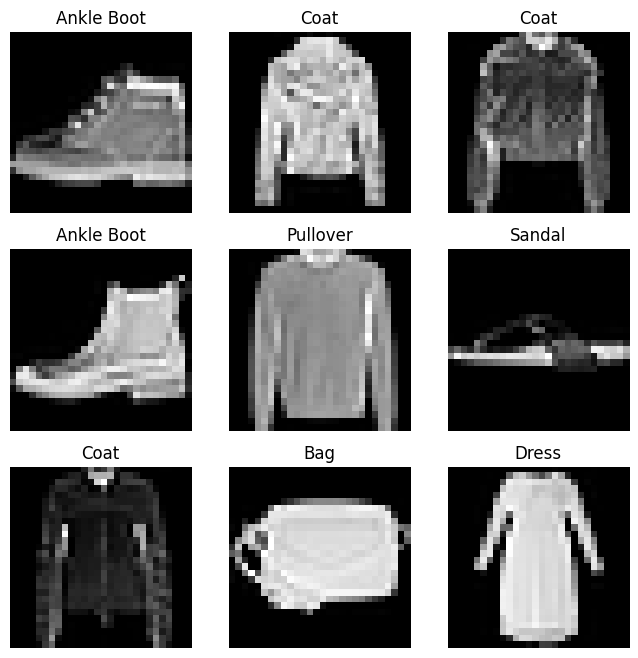

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Một lớp Dataset tùy chỉnh phải triển khai ba hàm: __init__, __len__, __getitem__:
- Hình ảnh FashionMNIST được lưu trữ trong folder img_dir
- Nhãn được lưu trữ riêng trong một tệp CSV annotations_file

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

CustomImageDataset là hàm kế thừa từ Dataset để load ảnh + nhãn từ file csv, có hỗ trợ transform nếu cần

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # lưu tên ảnh, nhãn vào img_labels
        # Lưu các tham số đầu vào thành biến của class
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels) # Hàm lấy số lượng mẫu dữ liệu
    
    def __getitem__(self, idx): # Hàm lấy phần tuwrt tại idx -> dùng khi load bằng dataloader
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0]) # lấy tên ảnh và nối vào thư mục ảnh để tạo path hoàn chỉnh của ảnh
        image = read_image(img_path) # đọc ảnh và trả về tensor có shape (C, H, W)
        label = self.img_labels.iloc[idx, 1] # lấy nhãn tương ứng với cột thứ 2 trong file csv
        if self.transform: 
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # Nếu có truyền hàm transform cho ảnh hoặc nhãn thì sẽ áp dụng.
        return image, label 

Hàm __init__ được chạy một lần khi khởi tạo đối tượng Dataset

_Khởi tạo:
- Thư mục chứa hình ảnh
- Tệp chú thích
- hai phép biến đổi

Hàm __len__ trả về số lượng mẫu trong tập dữ liệu của chúng ta

Hàm __getitem__ tải và trả về một mẫu từ tập dữ liệu tại chỉ mục đã cho idx

_Dựa trên chỉ mục:
- Nó xác định vị trí của hình ảnh trên đĩa
- Chuyển đổi vị trí đó thành tensor bằng cách sử dụng read_image
- Truy xuất nhãn tương ứng từ dữ liệu csv trong self.img_labels
- Gọi các hàm biến đổi trên chúng (nếu có)
- Trả về hình ảnh tensor và nhãn tương ứng trong một tuple

CHUẨN BỊ DỮ LIỆU ĐỂ TRAIN VỚI DATALOADER

Trong khi đào tạo một mô hình, truyền các mẫu theo "minibatch", sắp xếp lại dữ liệu ở mỗi thời điểm để giảm mô hình quá khớp và sử dụng Python multiprocessing để tăng tốc độ truy xuất dữ liệu.

In [8]:
from torch.utils.data import DataLoader

# Dataset lấy feature & label theo từng sample
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Vì đã chỉ định shuffle=True, sau khi lặp lại tất cả các lô, dữ liệu sẽ được xáo trộn

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


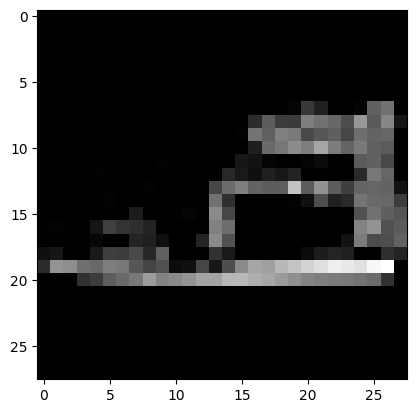

Label: 5


In [10]:
train_feature, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_feature.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_feature[0].squeeze() # Bỏ chiều dư thừa để matplotlib hiển thị được
label = train_labels[0] # lấy nhãn đầu tiền trong batch
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")